# Reprocessed GQuadruplex Annotations Genome Wide with all stabilities, not just Q > 19
- Examining how stability appears genome wide

In [16]:
df = pd.read_csv("/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_unfiltered_stability/verkko_batch123_chm13_collapsed_quadron_summary_metrics_combined.csv")
df = df[df["Sample_Haplotype"] == "HG00358_hap1"]
df

,Sample_Haplotype,Motif Type,Stability,Total Count,Total Bases Covered,Percent of Genome
74,HG00358_hap1,Negative_G_Quad,Stable,178406,6938155,0.237934
75,HG00358_hap1,Negative_G_Quad,Unstable,168168,5998809,0.205720
514,HG00358_hap1,Positive_G_Quad,Stable,179247,7004419,0.240206
515,HG00358_hap1,Positive_G_Quad,Unstable,169616,6018755,0.206404


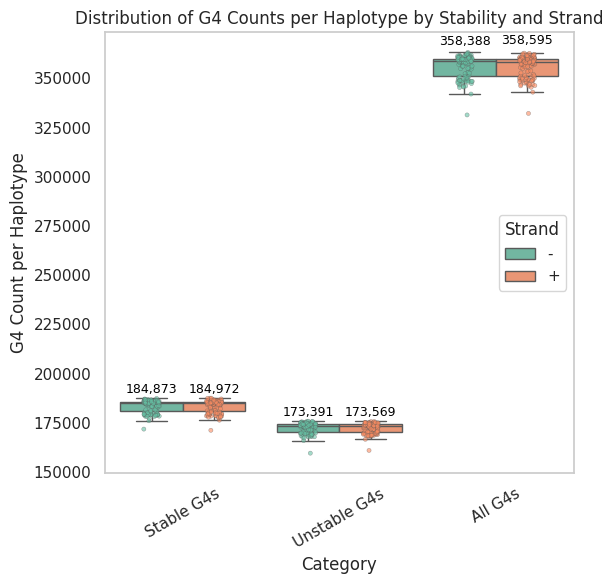

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_unfiltered_stability/verkko_batch123_chm13_collapsed_quadron_summary_metrics_combined.csv")

# Filter for G-quad motifs
df = df[df["Motif Type"].str.contains("G_Quad", case=False)]

# Extract strand from Motif Type
df["Strand"] = df["Motif Type"].str.extract(r'^(Positive|Negative)', expand=False)

# Group by haplotype, stability, and strand to get total counts
grouped = df.groupby(["Sample_Haplotype", "Stability", "Strand"])["Total Count"].sum().reset_index()

# Create a wide format table to make it easier to compute All G4s
stable_df = grouped[grouped["Stability"] == "Stable"]
unstable_df = grouped[grouped["Stability"] == "Unstable"]

# Merge stable and unstable to compute "All"
all_df = pd.merge(
    stable_df, unstable_df,
    on=["Sample_Haplotype", "Strand"],
    suffixes=("_Stable", "_Unstable"),
    how="outer"
).fillna(0)

all_df["Total Count"] = all_df["Total Count_Stable"] + all_df["Total Count_Unstable"]
all_df["Stability"] = "All"
all_df = all_df[["Sample_Haplotype", "Stability", "Strand", "Total Count"]]

# Recombine into one tidy long dataframe
long_df = pd.concat([
    stable_df[["Sample_Haplotype", "Stability", "Strand", "Total Count"]],
    unstable_df[["Sample_Haplotype", "Stability", "Strand", "Total Count"]],
    all_df
], ignore_index=True)

# Map strand for nicer labels
long_df["Strand"] = long_df["Strand"].map({"Positive": "+", "Negative": "-"})
long_df["Category"] = long_df["Stability"] + " G4s"

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
ax = sns.boxplot(
    data=long_df,
    x="Category", y="Total Count", hue="Strand",
    palette="Set2", showcaps=True, fliersize=0, linewidth=1
)
sns.stripplot(
    data=long_df,
    x="Category", y="Total Count", hue="Strand",
    dodge=True, palette="Set2", edgecolor="auto", linewidth=0.3,
    alpha=0.6, size=3, marker="o"
)

# Fix legend (remove duplicates)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Strand", loc="center right")

# Add median labels
medians = long_df.groupby(["Category", "Strand"])["Total Count"].median().reset_index()
for _, row in medians.iterrows():
    cat = row["Category"]
    strand = row["Strand"]
    median_val = row["Total Count"]
    
    x_pos = list(long_df["Category"].unique()).index(cat)
    offset = -0.2 if strand == "+" else 0.2
    ax.text(x_pos + offset, median_val + 0.02 * median_val, f"{int(median_val):,}",
            ha='center', va='bottom', fontsize=9, color='black')

# Final formatting
plt.ylabel("G4 Count per Haplotype")
plt.title("Distribution of G4 Counts per Haplotype by Stability and Strand")
plt.xticks(rotation=30)
plt.tight_layout()
ax.grid(False)
plt.show()


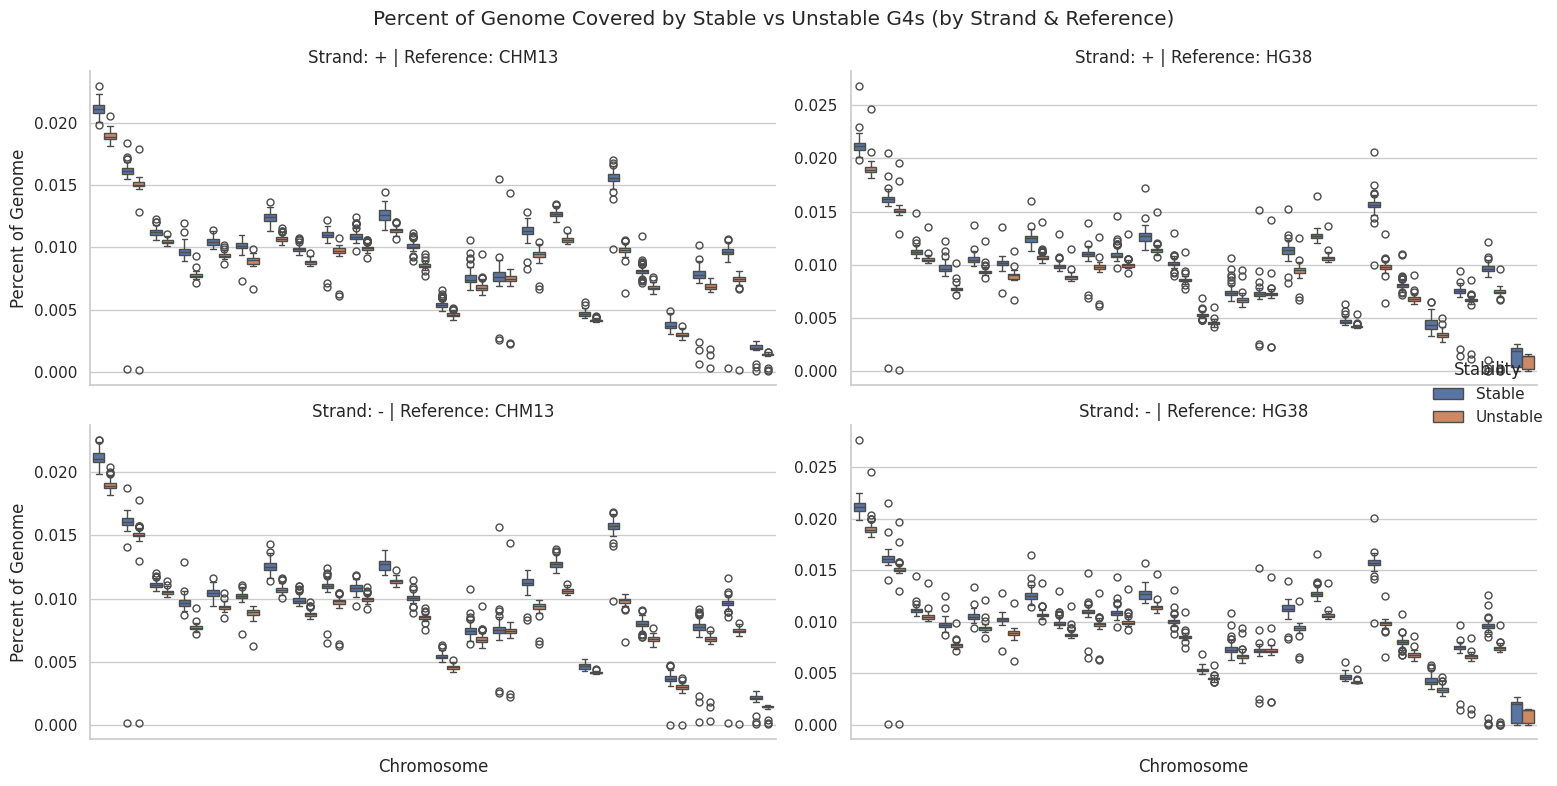

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSVs
chm13_df = pd.read_csv("/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_unfiltered_stability/verkko_batch123_chm13_collapsed_quadron_summary_metrics_combined_chr.csv")
hg38_df = pd.read_csv("/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_unfiltered_stability/verkko_batch123_hg38_collapsed_quadron_summary_metrics_combined_chr.csv")

# Add reference tags
chm13_df["Reference"] = "CHM13"
hg38_df["Reference"] = "HG38"

# Combine and filter
df = pd.concat([chm13_df, hg38_df], ignore_index=True)
df = df[df["Motif Type"].str.contains("G_Quad", case=False)]

# Extract strand info
df["Strand"] = df["Motif Type"].str.extract(r'^(Positive|Negative)', expand=False)
df["Strand"] = df["Strand"].map({"Positive": "+", "Negative": "-"})

# Clean chromosome values and set categorical order
def chr_sort_key(chr_name):
    chr_str = chr_name.replace("chr", "")
    if chr_str.isdigit():
        return int(chr_str)
    elif chr_str == "X":
        return 23
    elif chr_str == "Y":
        return 24
    elif chr_str in ["M", "MT"]:
        return 25
    else:
        return 100

unique_chrs = sorted(df["Chromosome"].unique(), key=chr_sort_key)
df["Chromosome"] = pd.Categorical(df["Chromosome"], categories=unique_chrs, ordered=True)

# Create faceted plot: row = strand, col = reference
g = sns.catplot(
    data=df,
    x="Chromosome", y="Percent of Genome",
    hue="Stability", col="Reference", row="Strand",
    kind="box", height=4, aspect=1.8, sharey=False
)

g.set_titles(row_template="Strand: {row_name}", col_template="Reference: {col_name}")
g.set_xticklabels(rotation=90)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Percent of Genome Covered by Stable vs Unstable G4s (by Strand & Reference)")
plt.tight_layout()
plt.show()


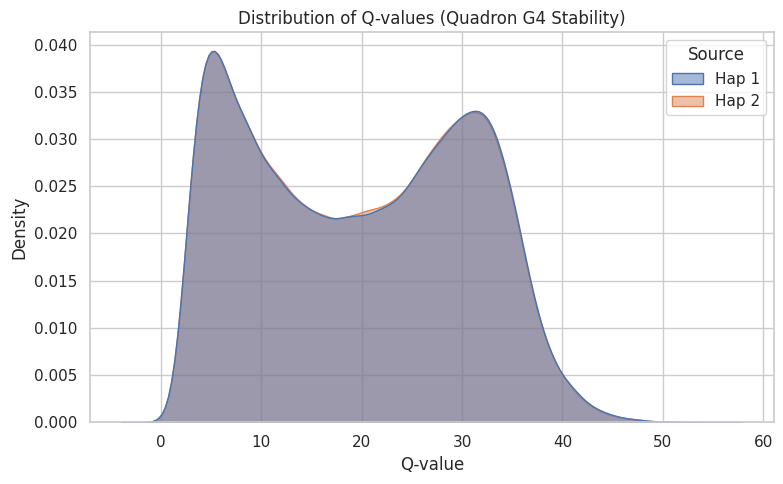

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load BED files (no header, 4 columns)
bed1 = pd.read_csv("/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/bed_files/all_Qs_quadron_beds/20230818_verkko_batch1_quadron_annotations_collapsed_chm13/HG00171_hap1_quadron_filtered_verkko_batch1_neg_collapsed.bed", sep='\t', header=None, names=["chr", "start", "end", "Q"])
bed2 = pd.read_csv("/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/bed_files/all_Qs_quadron_beds/20230818_verkko_batch1_quadron_annotations_collapsed_chm13/HG00171_hap2_quadron_filtered_verkko_batch1_neg_collapsed.bed", sep='\t', header=None, names=["chr", "start", "end", "Q"])

# Convert Q column to numeric
bed1["Q"] = pd.to_numeric(bed1["Q"], errors="coerce")
bed2["Q"] = pd.to_numeric(bed2["Q"], errors="coerce")

# Tag each with a source label
bed1["Source"] = "Hap 1"
bed2["Source"] = "Hap 2"

# Combine for plotting
df = pd.concat([bed1, bed2], ignore_index=True)

# Plot distribution using KDE or histogram
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Option 1: KDE (smoothed density)
sns.kdeplot(data=df, x="Q", hue="Source", fill=True, common_norm=False, alpha=0.5)

# Option 2: Histogram instead (comment above line and uncomment below if preferred)
# sns.histplot(data=df, x="Q", hue="Source", bins=50, element="step", stat="density", common_norm=False)

plt.title("Distribution of Q-values (Quadron G4 Stability)")
plt.xlabel("Q-value")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


Correlation between G4 length and stability: r = 0.054, p = 2.968e-228


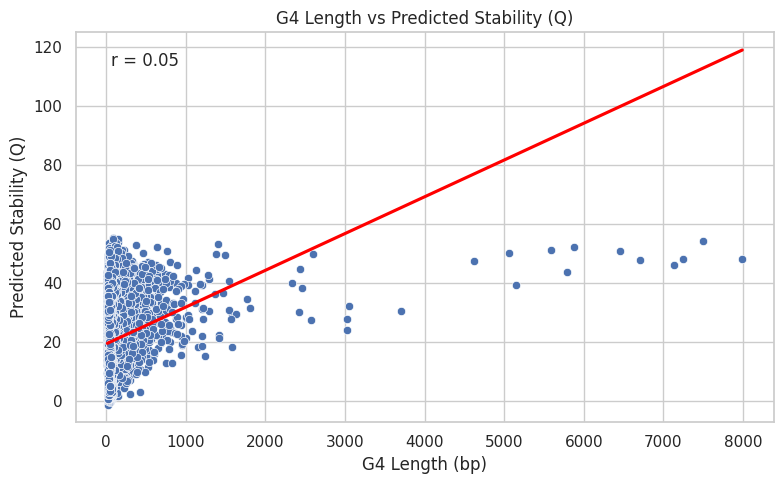

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load BED file
bed_path = "/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/bed_files/all_Qs_quadron_beds/20230818_verkko_batch1_quadron_annotations_collapsed_chm13/HG00171_hap1_quadron_filtered_verkko_batch1_neg_collapsed.bed"
df = pd.read_csv(bed_path, sep="\t", header=None, names=["Chromosome", "Start", "End", "Stability"])

# Convert columns to numeric
df['Start'] = pd.to_numeric(df['Start'], errors='coerce')
df['End'] = pd.to_numeric(df['End'], errors='coerce')
df['Stability'] = pd.to_numeric(df['Stability'], errors='coerce')

# Drop invalid rows
df = df.dropna(subset=['Start', 'End', 'Stability'])

# Compute G4 length
df['Length'] = df['End'] - df['Start']

# Correlation
corr = stats.pearsonr(df['Length'], df['Stability'])
print(f"Correlation between G4 length and stability: r = {corr[0]:.3f}, p = {corr[1]:.3e}")

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Length', y='Stability')
sns.regplot(data=df, x='Length', y='Stability', scatter=False, ci=None, color='red')
plt.title("G4 Length vs Predicted Stability (Q)")
plt.xlabel("G4 Length (bp)")
plt.ylabel("Predicted Stability (Q)")
plt.text(0.05, 0.95, f"r = {corr[0]:.2f}", transform=plt.gca().transAxes, ha='left', va='top', fontsize=12)
plt.tight_layout()
plt.show()


Correlation between G4 length and avg stability: r = 0.375, p = 1.531e-21


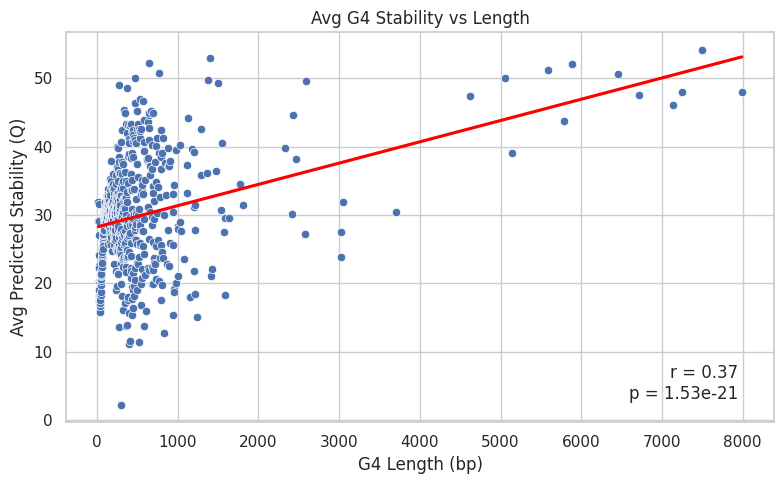

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load BED file
bed_path = "/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/bed_files/all_Qs_quadron_beds/20230818_verkko_batch1_quadron_annotations_collapsed_chm13/HG00171_hap1_quadron_filtered_verkko_batch1_neg_collapsed.bed"
df = pd.read_csv(bed_path, sep="\t", header=None, names=["Chromosome", "Start", "End", "Stability"])

# Clean
df['Start'] = pd.to_numeric(df['Start'], errors='coerce')
df['End'] = pd.to_numeric(df['End'], errors='coerce')
df['Stability'] = pd.to_numeric(df['Stability'], errors='coerce')
df = df.dropna(subset=['Start', 'End', 'Stability'])
df['Length'] = df['End'] - df['Start']

# Group by length and compute mean stability
length_avg = df.groupby('Length')['Stability'].mean().reset_index()

# Correlation on grouped means
corr = stats.pearsonr(length_avg['Length'], length_avg['Stability'])
print(f"Correlation between G4 length and avg stability: r = {corr[0]:.3f}, p = {corr[1]:.3e}")

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.scatterplot(data=length_avg, x='Length', y='Stability')
sns.regplot(data=length_avg, x='Length', y='Stability', scatter=False, ci=None, color='red')
plt.title("Avg G4 Stability vs Length")
plt.xlabel("G4 Length (bp)")
plt.ylabel("Avg Predicted Stability (Q)")
plt.text(0.95, 0.05, f"r = {corr[0]:.2f}\np = {corr[1]:.3g}", transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()


Correlation between G4 length and avg stability (Q > 19): r = 0.293, p = 4.556e-07


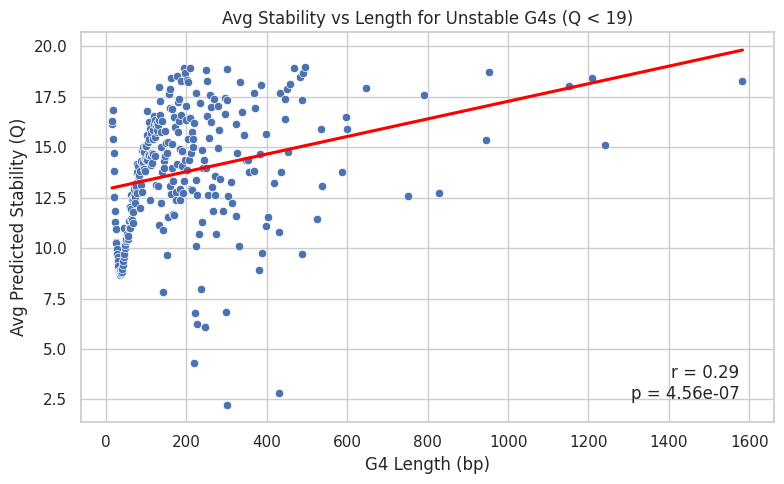

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load BED file
bed_path = "/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/bed_files/all_Qs_quadron_beds/20230818_verkko_batch1_quadron_annotations_collapsed_chm13/HG00171_hap1_quadron_filtered_verkko_batch1_neg_collapsed.bed"
df = pd.read_csv(bed_path, sep="\t", header=None, names=["Chromosome", "Start", "End", "Stability"])

# Clean
df['Start'] = pd.to_numeric(df['Start'], errors='coerce')
df['End'] = pd.to_numeric(df['End'], errors='coerce')
df['Stability'] = pd.to_numeric(df['Stability'], errors='coerce')
df = df.dropna(subset=['Start', 'End', 'Stability'])
df['Length'] = df['End'] - df['Start']

# Filter to stable G4s only (Stability > 19)
df = df[df['Stability'] <= 19]

# Group by length and compute mean stability
length_avg = df.groupby('Length')['Stability'].mean().reset_index()

# Correlation on grouped means
corr = stats.pearsonr(length_avg['Length'], length_avg['Stability'])
print(f"Correlation between G4 length and avg stability (Q > 19): r = {corr[0]:.3f}, p = {corr[1]:.3e}")

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.scatterplot(data=length_avg, x='Length', y='Stability')
sns.regplot(data=length_avg, x='Length', y='Stability', scatter=False, ci=None, color='red')
plt.title("Avg Stability vs Length for Unstable G4s (Q < 19)")
plt.xlabel("G4 Length (bp)")
plt.ylabel("Avg Predicted Stability (Q)")
plt.text(0.95, 0.05, f"r = {corr[0]:.2f}\np = {corr[1]:.3g}", transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()

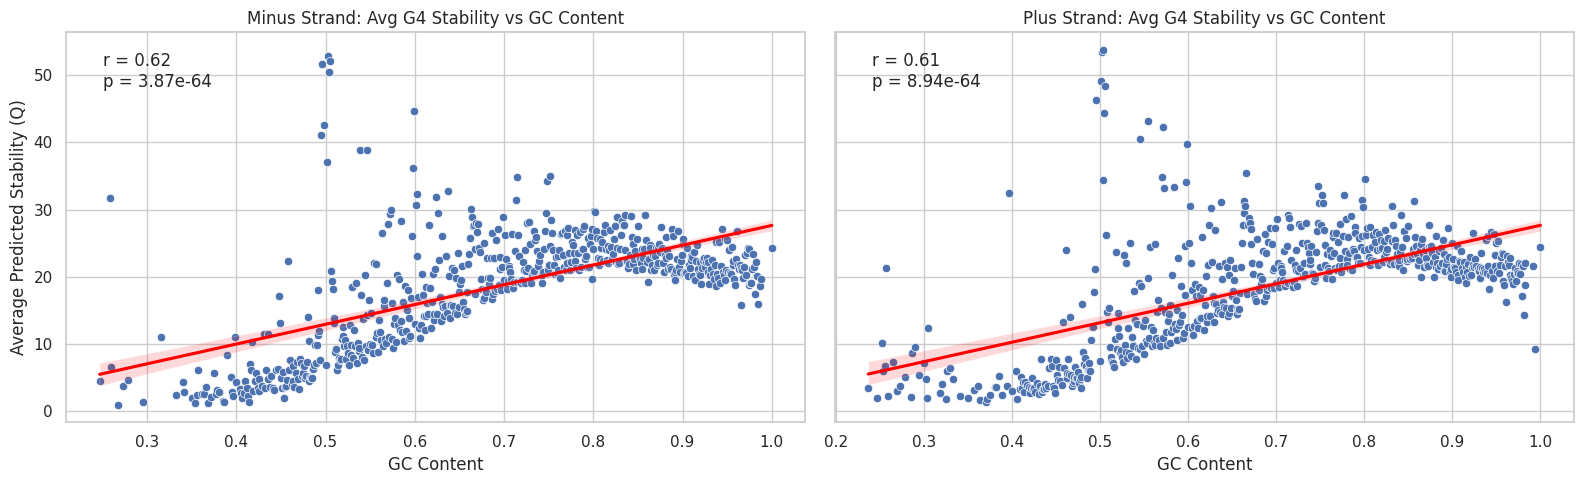

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load data
df = pd.read_csv("/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/quadron_all_q_filtered_csvs/20230818_verkko_batch1_assemblies_aligned_hg38_collapsed/HG00171_hap1_quadron_filtered_verkko_batch1.csv")  # Replace with your file path

# Compute GC content (rounded to 3 decimals)
df['G_count'] = df['Sequence'].str.count('G')
df['C_count'] = df['Sequence'].str.count('C')
df['GC_content'] = ((df['G_count'] + df['C_count']) / df['Sequence'].str.len()).round(3)

# Separate + and - strand data
df_plus = df[df['STR'] == '+']
df_minus = df[df['STR'] == '-']

# Group by GC content and compute average Q for each strand
gc_avg_plus = df_plus.groupby('GC_content')['Q'].mean().reset_index().dropna()
gc_avg_minus = df_minus.groupby('GC_content')['Q'].mean().reset_index().dropna()

# Compute correlations
r_plus, p_plus = pearsonr(gc_avg_plus['GC_content'], gc_avg_plus['Q'])
r_minus, p_minus = pearsonr(gc_avg_minus['GC_content'], gc_avg_minus['Q'])

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Minus strand plot
sns.scatterplot(ax=axes[0], data=gc_avg_minus, x='GC_content', y='Q')
sns.regplot(ax=axes[0], data=gc_avg_minus, x='GC_content', y='Q', scatter=False, color='red')
axes[0].set_title("Minus Strand: Avg G4 Stability vs GC Content")
axes[0].set_xlabel("GC Content")
axes[0].set_ylabel("Average Predicted Stability (Q)")
axes[0].text(0.05, 0.95, f"r = {r_minus:.2f}\np = {p_minus:.2e}",
             transform=axes[0].transAxes, ha='left', va='top', fontsize=12)

# Plus strand plot
sns.scatterplot(ax=axes[1], data=gc_avg_plus, x='GC_content', y='Q')
sns.regplot(ax=axes[1], data=gc_avg_plus, x='GC_content', y='Q', scatter=False, color='red')
axes[1].set_title("Plus Strand: Avg G4 Stability vs GC Content")
axes[1].set_xlabel("GC Content")
axes[1].set_ylabel("")  # Hide duplicate y-label
axes[1].text(0.05, 0.95, f"r = {r_plus:.2f}\np = {p_plus:.2e}",
             transform=axes[1].transAxes, ha='left', va='top', fontsize=12)

plt.tight_layout()
plt.show()

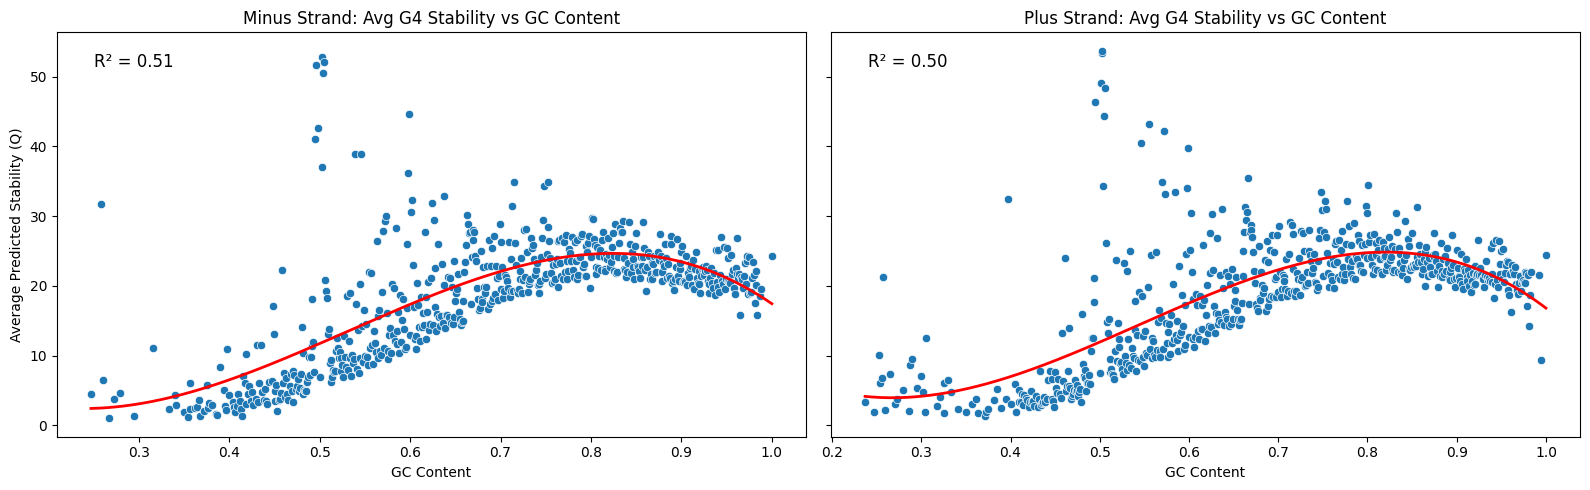

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score

# === Load data
df = pd.read_csv("/home/alextu/scratch/HG00171_hap1_quadron_filtered_verkko_batch1.csv")

# === Compute GC content
df['G_count'] = df['Sequence'].str.count('G')
df['C_count'] = df['Sequence'].str.count('C')
df['GC_content'] = ((df['G_count'] + df['C_count']) / df['Sequence'].str.len()).round(3)

# === Split by strand
df_plus = df[df['STR'] == '+']
df_minus = df[df['STR'] == '-']

# === Group by GC content
gc_avg_plus = df_plus.groupby('GC_content')['Q'].mean().reset_index().dropna()
gc_avg_minus = df_minus.groupby('GC_content')['Q'].mean().reset_index().dropna()

# === Polynomial fitting and R²
def fit_poly_and_r2(x, y, degree=3):
    coeffs = np.polyfit(x, y, degree)
    poly = np.poly1d(coeffs)
    r2 = r2_score(y, poly(x))
    return coeffs, poly, r2

# Fit polynomials
coeffs_minus, poly_minus, r2_minus = fit_poly_and_r2(gc_avg_minus['GC_content'], gc_avg_minus['Q'])
coeffs_plus, poly_plus, r2_plus = fit_poly_and_r2(gc_avg_plus['GC_content'], gc_avg_plus['Q'])

# === Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Minus strand
sns.scatterplot(ax=axes[0], data=gc_avg_minus, x='GC_content', y='Q')
x_vals = np.linspace(gc_avg_minus['GC_content'].min(), gc_avg_minus['GC_content'].max(), 500)
axes[0].plot(x_vals, poly_minus(x_vals), color='red', linewidth=2)
axes[0].set_title("Minus Strand: Avg G4 Stability vs GC Content")
axes[0].set_xlabel("GC Content")
axes[0].set_ylabel("Average Predicted Stability (Q)")
axes[0].text(0.05, 0.95, f"R² = {r2_minus:.2f}", transform=axes[0].transAxes,
             ha='left', va='top', fontsize=12)

# Plus strand
sns.scatterplot(ax=axes[1], data=gc_avg_plus, x='GC_content', y='Q')
x_vals = np.linspace(gc_avg_plus['GC_content'].min(), gc_avg_plus['GC_content'].max(), 500)
axes[1].plot(x_vals, poly_plus(x_vals), color='red', linewidth=2)
axes[1].set_title("Plus Strand: Avg G4 Stability vs GC Content")
axes[1].set_xlabel("GC Content")
axes[1].set_ylabel("")  # no y-label for symmetry
axes[1].text(0.05, 0.95, f"R² = {r2_plus:.2f}", transform=axes[1].transAxes,
             ha='left', va='top', fontsize=12)

plt.tight_layout()
plt.show()

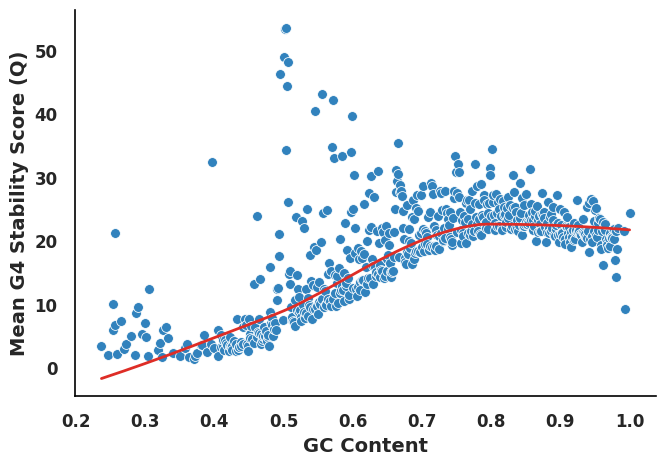

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Seaborn + Matplotlib publication settings
sns.set_context("talk")  # Larger fonts
sns.set_style("white")   # White background, no grid
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "bold"

# === Load data
df = pd.read_csv("/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/quadron_all_q_filtered_csvs/20230818_verkko_batch1_assemblies_aligned_chm13_collapsed/HG00171_hap1_quadron_filtered_verkko_batch1.csv")

# === Compute GC content
df['G_count'] = df['Sequence'].str.count('G')
df['C_count'] = df['Sequence'].str.count('C')
df['GC_content'] = ((df['G_count'] + df['C_count']) / df['Sequence'].str.len()).round(3)

# === Filter for minus strand only
df_minus = df[df['STR'] == '+']

# === Group by GC content and average stability
gc_avg_minus = df_minus.groupby('GC_content')['Q'].mean().reset_index().dropna()

# === Plot
fig, ax = plt.subplots(figsize=(7, 5))

sns.scatterplot(data=gc_avg_minus, x='GC_content', y='Q', color="#3182bd", s=50)
sns.regplot(data=gc_avg_minus, x='GC_content', y='Q', lowess=True,
            scatter=False, color="#de2d26", line_kws={"lw": 2})

#ax.set_title("G4 Stability vs GC Content", fontsize=16, weight='bold')
ax.set_xlabel("GC Content", fontsize=14)
ax.set_ylabel("Mean G4 Stability Score (Q)", fontsize=14)

# Bold tick labels
for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')

for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')

ax.tick_params(labelsize=12)
sns.despine()

plt.tight_layout()
plt.savefig('/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/g4_stability_vs_gc_content.pdf', bbox_inches='tight', dpi=300)
plt.show()

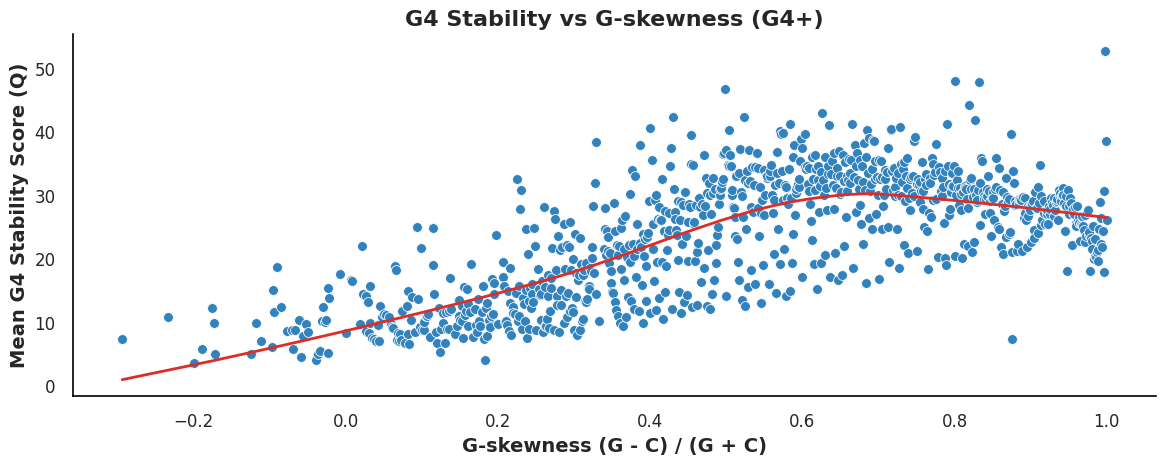

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Seaborn + Matplotlib publication settings
sns.set_context("talk")
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "bold"

# === Load data
df = pd.read_csv("/home/alextu/scratch/HG00171_hap1_quadron_filtered_verkko_batch1.csv")

# === Count G and C bases
df['G_count'] = df['Sequence'].str.count('G')
df['C_count'] = df['Sequence'].str.count('C')

# === Compute G-skew: (G - C) / (G + C)
df['G_skew'] = (df['G_count'] - df['C_count']) / (df['G_count'] + df['C_count'])
df['G_skew'] = df['G_skew'].replace([np.inf, -np.inf], np.nan).round(3)

# === Filter for minus strand only
df_minus = df[df['STR'] == '+']

# === Group by G-skew and compute mean Q
gskew_avg_minus = df_minus.groupby('G_skew')['Q'].mean().reset_index().dropna()

# === Plot
fig, ax = plt.subplots(figsize=(12, 5))

sns.scatterplot(data=gskew_avg_minus, x='G_skew', y='Q', color="#3182bd", s=50)
sns.regplot(data=gskew_avg_minus, x='G_skew', y='Q', lowess=True,
            scatter=False, color="#de2d26", line_kws={"lw": 2})

ax.set_title("G4 Stability vs G-skewness (G4+)", fontsize=16, weight='bold')
ax.set_xlabel("G-skewness (G - C) / (G + C)", fontsize=14)
ax.set_ylabel("Mean G4 Stability Score (Q)", fontsize=14)

ax.tick_params(labelsize=12)
sns.despine()

plt.tight_layout()
plt.show()

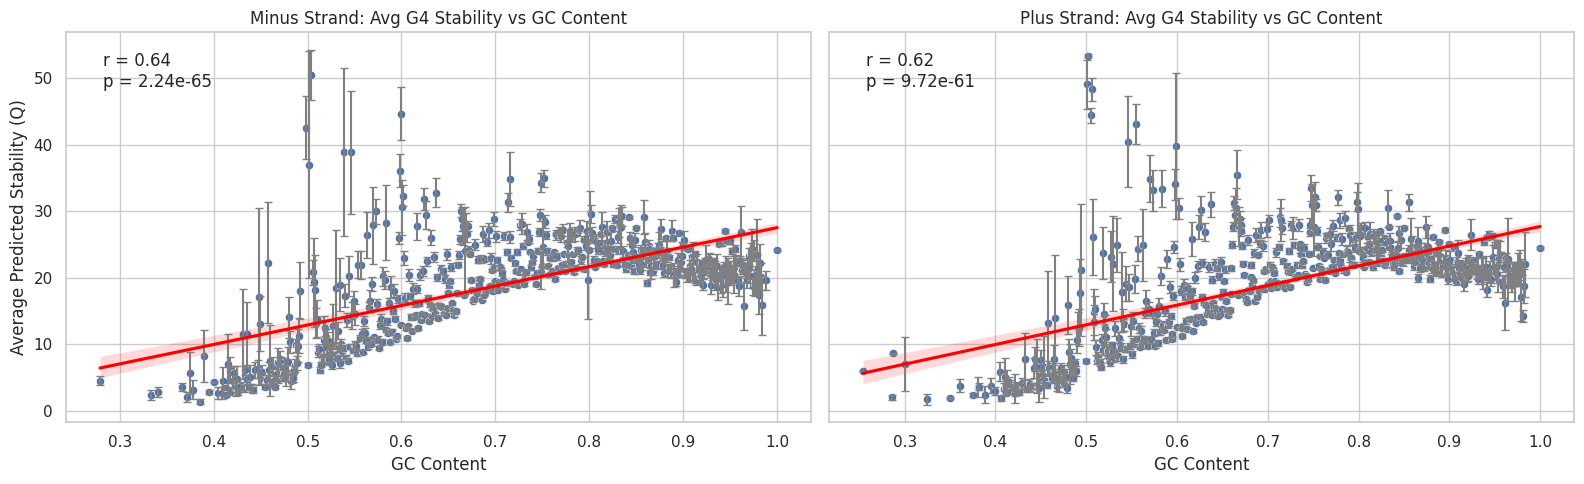

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load data
df = pd.read_csv("/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/quadron_all_q_filtered_csvs/20230818_verkko_batch1_assemblies_aligned_hg38_collapsed/HG00171_hap1_quadron_filtered_verkko_batch1.csv")

# Compute GC content (rounded to 3 decimals)
df['G_count'] = df['Sequence'].str.count('G')
df['C_count'] = df['Sequence'].str.count('C')
df['GC_content'] = ((df['G_count'] + df['C_count']) / df['Sequence'].str.len()).round(3)

# Separate + and - strand data
df_plus = df[df['STR'] == '+']
df_minus = df[df['STR'] == '-']

# Group by GC content and compute mean, std, count, sem
gc_avg_plus = df_plus.groupby('GC_content')['Q'].agg(['mean', 'std', 'count']).reset_index()
gc_avg_plus['sem'] = gc_avg_plus['std'] / gc_avg_plus['count']**0.5
gc_avg_plus = gc_avg_plus.dropna()

gc_avg_minus = df_minus.groupby('GC_content')['Q'].agg(['mean', 'std', 'count']).reset_index()
gc_avg_minus['sem'] = gc_avg_minus['std'] / gc_avg_minus['count']**0.5
gc_avg_minus = gc_avg_minus.dropna()

# Compute correlations
r_plus, p_plus = pearsonr(gc_avg_plus['GC_content'], gc_avg_plus['mean'])
r_minus, p_minus = pearsonr(gc_avg_minus['GC_content'], gc_avg_minus['mean'])

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Minus strand
sns.scatterplot(ax=axes[0], data=gc_avg_minus, x='GC_content', y='mean')
axes[0].errorbar(gc_avg_minus['GC_content'], gc_avg_minus['mean'], yerr=gc_avg_minus['sem'],
                 fmt='none', capsize=3, color='gray')
sns.regplot(ax=axes[0], data=gc_avg_minus, x='GC_content', y='mean', scatter=False, color='red')
axes[0].set_title("Minus Strand: Avg G4 Stability vs GC Content")
axes[0].set_xlabel("GC Content")
axes[0].set_ylabel("Average Predicted Stability (Q)")
axes[0].text(0.05, 0.95, f"r = {r_minus:.2f}\np = {p_minus:.2e}",
             transform=axes[0].transAxes, ha='left', va='top', fontsize=12)

# Plus strand
sns.scatterplot(ax=axes[1], data=gc_avg_plus, x='GC_content', y='mean')
axes[1].errorbar(gc_avg_plus['GC_content'], gc_avg_plus['mean'], yerr=gc_avg_plus['sem'],
                 fmt='none', capsize=3, color='gray')
sns.regplot(ax=axes[1], data=gc_avg_plus, x='GC_content', y='mean', scatter=False, color='red')
axes[1].set_title("Plus Strand: Avg G4 Stability vs GC Content")
axes[1].set_xlabel("GC Content")
axes[1].set_ylabel("")  # Hide duplicate y-axis label
axes[1].text(0.05, 0.95, f"r = {r_plus:.2f}\np = {p_plus:.2e}",
             transform=axes[1].transAxes, ha='left', va='top', fontsize=12)

plt.tight_layout()
plt.show()

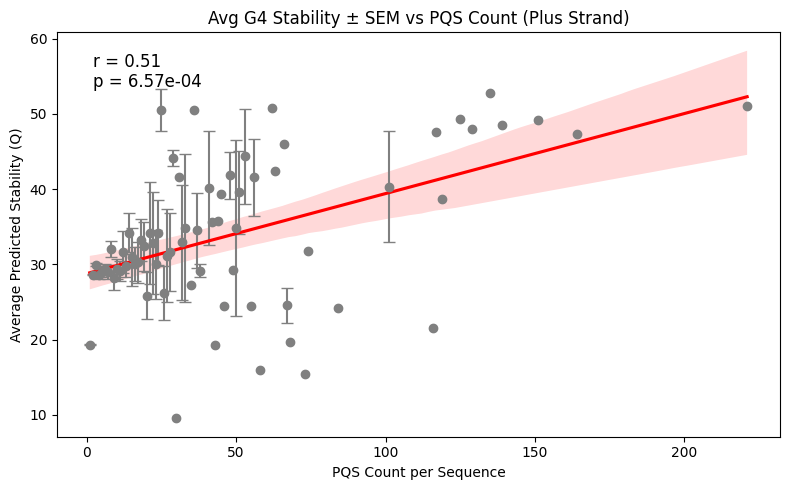

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import pearsonr

# === Load data
df = pd.read_csv("/home/alextu/scratch/HG00171_hap1_quadron_filtered_verkko_batch1.csv")

# === PQS pattern
Lmax = 12
pqs_pattern = re.compile(
    fr'(G{{3,}}[ACGTN]{{1,{Lmax}}}G{{3,}}[ACGTN]{{1,{Lmax}}}G{{3,}}[ACGTN]{{1,{Lmax}}}G{{3,}})'
)

# === Filter to plus strand
df = df[df['STR'] == '+'].copy()
df['PQS_count'] = df['Sequence'].apply(lambda seq: len(pqs_pattern.findall(seq)))

# === Group by PQS_count
summary = df.groupby('PQS_count')['Q'].agg(['mean', 'std', 'count']).reset_index()
summary['sem'] = summary['std'] / summary['count']**0.5

# === Drop NaNs and compute correlation
corr_df = summary.dropna()
if corr_df['PQS_count'].nunique() > 1 and corr_df['mean'].nunique() > 1:
    r, p = pearsonr(corr_df['PQS_count'], corr_df['mean'])
else:
    r, p = float('nan'), float('nan')

# === Plot: scatter of means + error bars + regression line
plt.figure(figsize=(8, 5))
sns.scatterplot(data=summary, x='PQS_count', y='mean')
plt.errorbar(summary['PQS_count'], summary['mean'], yerr=summary['sem'],
             fmt='o', capsize=4, color='gray')

# Overlay regression line
sns.regplot(data=summary, x='PQS_count', y='mean', scatter=False, color='red')

plt.title("Avg G4 Stability ± SEM vs PQS Count (Plus Strand)")
plt.xlabel("PQS Count per Sequence")
plt.ylabel("Average Predicted Stability (Q)")
plt.text(0.05, 0.95, f"r = {r:.2f}\np = {p:.2e}", transform=plt.gca().transAxes,
         ha='left', va='top', fontsize=12)
plt.tight_layout()
plt.show()

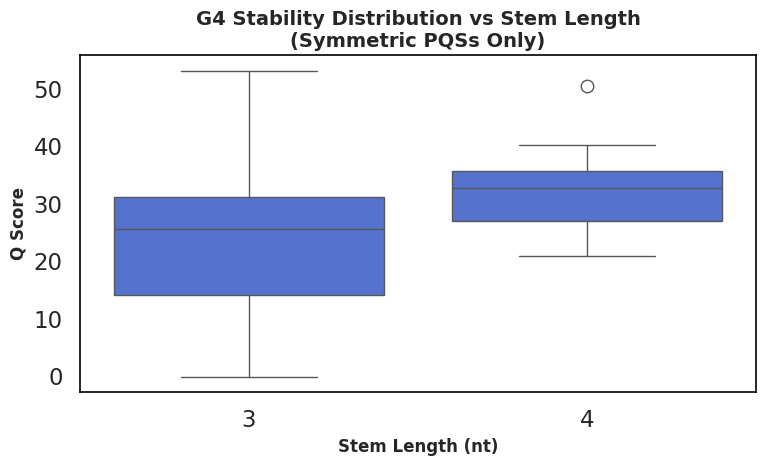

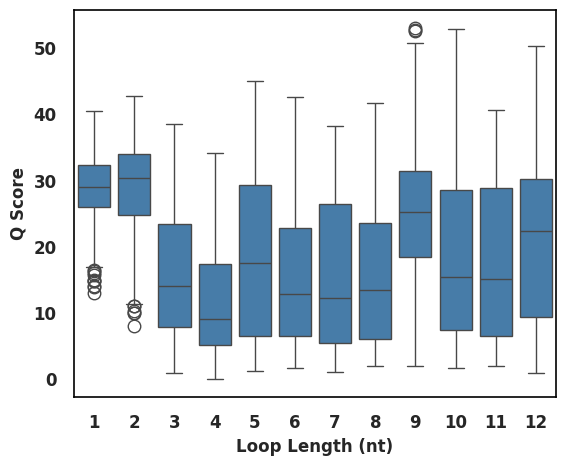

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import sem, pearsonr

# === Load Quadron data
df = pd.read_csv("/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/quadron_all_q_filtered_csvs/20230818_verkko_batch1_assemblies_aligned_chm13_collapsed/HG00171_hap1_quadron_filtered_verkko_batch1.csv")

# === PQS pattern (Quadron definition)
Lmax = 12
pattern = re.compile(
    fr'(G{{3,}})'               # Stem1
    fr'(.{{1,{Lmax}}})'         # Loop1
    fr'(G{{3,}})'               # Stem2
    fr'(.{{1,{Lmax}}})'         # Loop2
    fr'(G{{3,}})'               # Stem3
    fr'(.{{1,{Lmax}}})'         # Loop3
    fr'(G{{3,}})'               # Stem4
)

# === Extract only symmetric PQSs (equal stem + loop lengths)
def extract_if_uniform(seq):
    match = pattern.search(seq)
    if match:
        stems = [match.group(i) for i in [1, 3, 5, 7]]
        loops = [match.group(i) for i in [2, 4, 6]]
        stem_lens = list(map(len, stems))
        loop_lens = list(map(len, loops))
        if len(set(stem_lens)) == 1 and len(set(loop_lens)) == 1:
            return pd.Series({
                'Stem_Length': stem_lens[0],
                'Loop_Length': loop_lens[0]
            })
    return pd.Series({'Stem_Length': None, 'Loop_Length': None})

# === Apply extraction
features = df['Sequence'].apply(extract_if_uniform)
df_uniform = pd.concat([df, features], axis=1).dropna()

# === Optional: filter by count (keep only groups with ≥10 PQSs)
stem_counts = df_uniform['Stem_Length'].value_counts()
loop_counts = df_uniform['Loop_Length'].value_counts()
valid_stems = stem_counts[stem_counts >= 10].index
valid_loops = loop_counts[loop_counts >= 10].index

df_filtered = df_uniform[
    df_uniform['Stem_Length'].isin(valid_stems) &
    df_uniform['Loop_Length'].isin(valid_loops)
]

df_filtered['Stem_Length'] = df_filtered['Stem_Length'].astype(int)
df_filtered['Loop_Length'] = df_filtered['Loop_Length'].astype(int)

# === Boxplot: Q vs Stem Length
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_filtered, x='Stem_Length', y='Q', color='royalblue')
plt.title("G4 Stability Distribution vs Stem Length\n(Symmetric PQSs Only)", fontsize=14, weight='bold')
plt.xlabel("Stem Length (nt)", fontsize=12)
plt.ylabel("Q Score", fontsize=12)
plt.tight_layout()
plt.show()

# === Boxplot: Q vs Loop Length
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_filtered, x='Loop_Length', y='Q', color='#377eb8')
#plt.title("G4 Stability vs Loop Length", fontsize=14, weight='bold')
plt.xlabel("Loop Length (nt)", fontsize=12, fontweight='bold')
plt.ylabel("Q Score", fontsize=12, fontweight='bold')
# Bold tick labels
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.tight_layout()
plt.savefig('/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/G4_loop_stability.pdf', bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_147377/3371988407.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_labeled, x='Symmetry', y='Q',


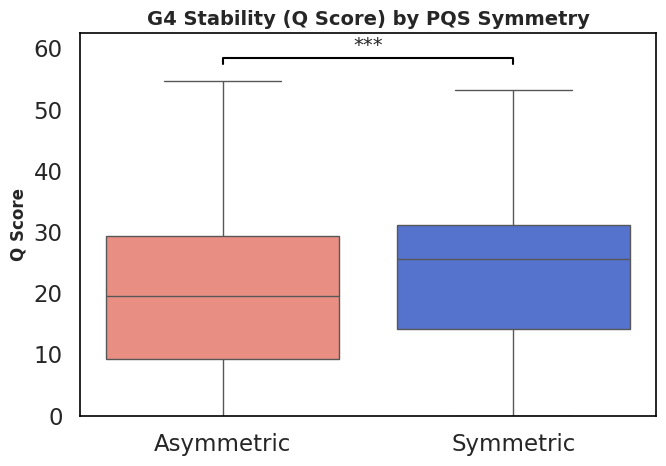

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import mannwhitneyu

# === Load data
df = pd.read_csv("/home/alextu/scratch/HG00171_hap1_quadron_filtered_verkko_batch1.csv")

# === PQS regex pattern
Lmax = 12
pattern = re.compile(
    fr'(G{{3,}})'               # Stem1
    fr'(.{{1,{Lmax}}})'         # Loop1
    fr'(G{{3,}})'               # Stem2
    fr'(.{{1,{Lmax}}})'         # Loop2
    fr'(G{{3,}})'               # Stem3
    fr'(.{{1,{Lmax}}})'         # Loop3
    fr'(G{{3,}})'               # Stem4
)

# === Function to classify PQSs as symmetric or asymmetric
def classify_symmetry(seq):
    match = pattern.search(seq)
    if match:
        stems = [len(match.group(i)) for i in [1, 3, 5, 7]]
        loops = [len(match.group(i)) for i in [2, 4, 6]]
        is_symmetric = (len(set(stems)) == 1) and (len(set(loops)) == 1)
        return pd.Series({'Symmetry': 'Symmetric' if is_symmetric else 'Asymmetric'})
    return pd.Series({'Symmetry': None})

# === Apply classification
symmetry_col = df['Sequence'].apply(classify_symmetry)
df_labeled = pd.concat([df, symmetry_col], axis=1).dropna(subset=['Symmetry', 'Q'])

# === Subset groups
sym_q = df_labeled[df_labeled['Symmetry'] == 'Symmetric']['Q']
asym_q = df_labeled[df_labeled['Symmetry'] == 'Asymmetric']['Q']

# === Mann–Whitney U test
if len(sym_q) > 0 and len(asym_q) > 0:
    stat, p = mannwhitneyu(sym_q, asym_q, alternative='two-sided')
    if p < 0.001:
        p_label = "***"
    elif p < 0.01:
        p_label = "**"
    elif p < 0.05:
        p_label = "*"
    else:
        p_label = "ns"
else:
    p_label = "n/a"

# === Boxplot
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=df_labeled, x='Symmetry', y='Q',
                 palette={'Symmetric': 'royalblue', 'Asymmetric': 'salmon'})

# === Draw comparison line and label
y_max = df_labeled['Q'].max()
y_offset = y_max * 0.05
y_bar = y_max + y_offset
x1, x2 = 0, 1  # index of categories

# Horizontal line
plt.plot([x1, x1, x2, x2], [y_bar, y_bar + 1, y_bar + 1, y_bar], lw=1.5, color='black')

# Asterisk label
plt.text((x1 + x2) / 2, y_bar + 1.5, p_label, ha='center', va='bottom', fontsize=14)

plt.title("G4 Stability (Q Score) by PQS Symmetry", fontsize=14, weight='bold')
plt.xlabel("")
plt.ylabel("Q Score", fontsize=12)
plt.ylim(0, y_bar + 5)
plt.tight_layout()
plt.show()